In [1]:
import pymc as pm
import pandas as pd
import nutpie
import aesara.tensor as at
from utils import rcspline_eval, h
import matplotlib.pyplot as plt
import numpy as np
import patsy as pt
import arviz as az
import xarray as xr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Load in data
df = pd.read_csv("https://raw.githubusercontent.com/HPCurtis/Datasets/main/sicily.csv")
df.head(2)

,Unnamed: 0,year,month,aces,time,smokban,pop,stdpop,rate
0,1,2002,1,728,1,0,364277.4,379875.3,191.641836
1,2,2002,2,659,2,0,364277.4,376495.5,175.035293


Text(0, 0.5, 'Acute Coronary Cases Per 100,000')

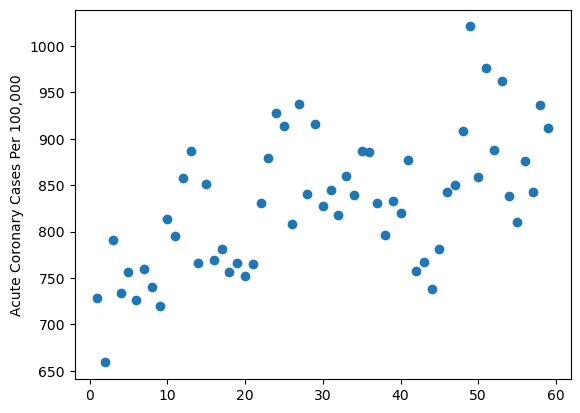

In [3]:
# Visualsie the data.
plt.scatter(x=df.time, y=df.aces);
plt.ylabel('Acute Coronary Cases Per 100,000')

In [17]:
# Generate restricted cubic spline (rcs).

# jump componet is the factor for causal effect.
jump_component = (df.time >= 37).astype(int)
# generate desing matrices for rcs and rcs with cyclical components
dm, knots = rcspline_eval(df.time, nk = 6)
dm_cyl = h(df.time, knots=knots)

# Add causal parameter to cyclical model.
dm = np.column_stack((dm, jump_component))
dm_cyl = np.column_stack((dm_cyl, jump_component))

# Add offet to mode matrix
offset = np.log(df['stdpop']).values


In [18]:
def run_mod(dm):
    with pm.Model() as model:
        # Priors
        alpha = pm.Normal("alpha", mu=0, sigma=10)
        beta = pm.Normal("beta", mu=0, sigma=10, shape=dm.shape[1]) 

        # Calculate predicted values from model. 
        mu = pm.Deterministic("mu",
            alpha + offset + 
            pm.math.dot(dm, beta)
        )
        
        # Poisson rate parameter
        lambda_ = pm.Deterministic("lamda", pm.math.exp(mu)) 
        
        # Likelihood
        y = pm.Poisson("y", mu=lambda_, observed=df['rate'])
        trace = pm.sample(nuts_sampler="numpyro")
        pm.compute_log_likelihood(trace)
        return trace

In [19]:
trace = run_mod(dm)
trace_cyl = run_mod(dm_cyl)

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]





Running chain 0:  25%|██▌       | 500/2000 [00:01<00:00, 4189.52it/s]


Running chain 0:  70%|███████   | 1400/2000 [00:01<00:00, 3978.58it/s]


Running chain 0:  90%|█████████ | 1800/2000 [00:01<00:00, 3707.81it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1139.63it/s]


/home/harrison/anaconda3/envs/pymc_env/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 0:  15%|█▌        | 300/2000 [00:01<00:00, 2593.32it/s]


Running chain 0:  30%|███       | 600/2000 [00:01<00:00, 2612.52it/s]




Running chain 0:  50%|█████     | 1000/2000 [00:01<00:00, 2791.86it/s]


Running chain 0:  65%|██████▌   | 1300/2000 [00:01<00:00, 2545.29it/s]


Running chain 0:  80%|████████  | 1600/2000 [00:01<00:00, 2380.07it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:02<00:00, 913.54it/s] 


/home/harrison/anaconda3/envs/pymc_env/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [20]:
az.summary(trace , var_names=["alpha","beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-7.539,0.019,-7.574,-7.505,0.000,0.000,1565.0,1825.0,1.00
beta[0],0.056,0.022,0.011,0.096,0.001,0.001,746.0,1375.0,1.00
beta[1],-0.175,0.085,-0.325,-0.002,0.003,0.002,708.0,1137.0,1.00
beta[2],0.252,0.147,-0.027,0.537,0.005,0.004,720.0,1035.0,1.01
beta[3],-0.236,0.181,-0.574,0.113,0.006,0.004,1062.0,1222.0,1.00
beta[4],-0.109,0.059,-0.219,0.001,0.001,0.001,1772.0,1934.0,1.00


In [11]:
az.summary(trace_cyl , var_names=["alpha","beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-7.541,0.019,-7.575,-7.505,0.000,0.000,2214.0,2080.0,1.0
beta[0],0.054,0.021,0.015,0.096,0.001,0.000,1123.0,1394.0,1.0
beta[1],-0.164,0.082,-0.318,-0.010,0.003,0.002,1065.0,1309.0,1.0
beta[2],0.230,0.144,-0.035,0.497,0.004,0.003,1048.0,1668.0,1.0
beta[3],-0.214,0.178,-0.536,0.135,0.005,0.003,1301.0,2020.0,1.0
beta[4],0.032,0.013,0.008,0.055,0.000,0.000,3315.0,2669.0,1.0
beta[5],0.037,0.013,0.014,0.062,0.000,0.000,3324.0,2815.0,1.0
beta[6],-0.130,0.062,-0.244,-0.013,0.001,0.001,2713.0,2483.0,1.0


/home/harrison/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/lmplot.py:211: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


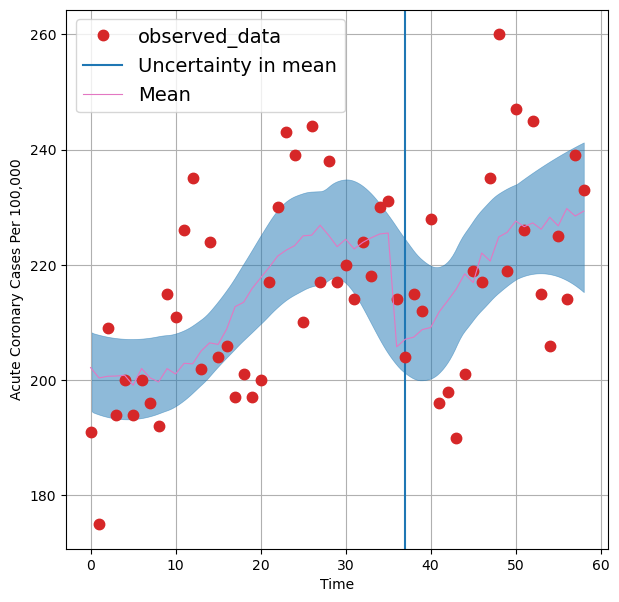

In [21]:
_, ax = plt.subplots(figsize=(7, 7));
az.plot_lm(idata=trace, y="y", num_samples=500, axes=ax, y_model="lamda", kind_model="hdi");
plt.axvline(37)
plt.ylabel('Acute Coronary Cases Per 100,000');
plt.xlabel('Time');

/home/harrison/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/lmplot.py:211: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


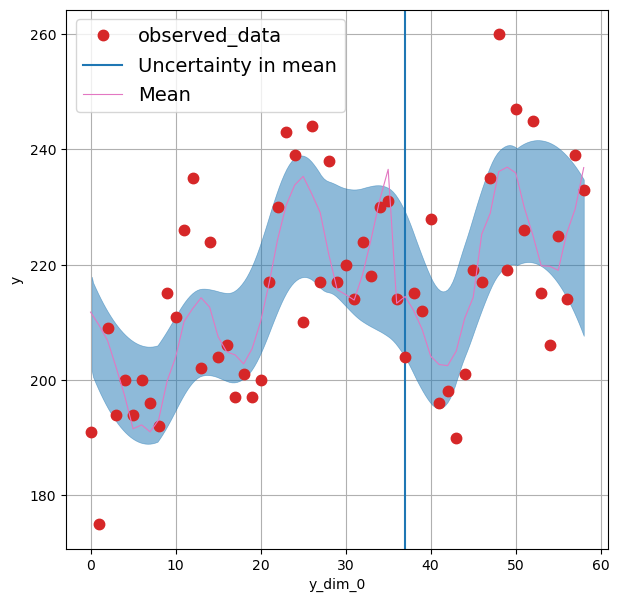

In [67]:
_, ax = plt.subplots(figsize=(7, 7));
az.plot_lm(idata=trace_cyl, y="y", num_samples=500, axes=ax, y_model="lambda", kind_model="hdi");
plt.axvline(37);

# Model comparison

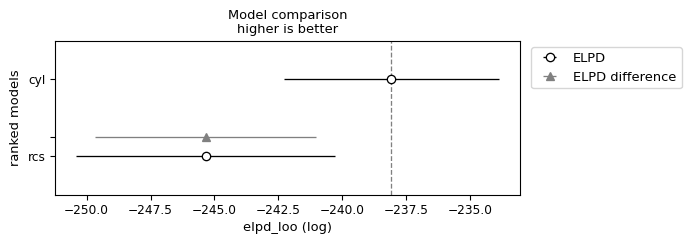

In [108]:
df_comp_loo = az.compare({"rcs": trace, "cyl": trace_cyl})
az.plot_compare(df_comp_loo, insample_dev=False);

# References

Stone, C. J., & Koo, C. Y. (1985). Additive splines in statistics. Proceedings of the Statistical Computing Section ASA, 45–48.